# Quais os principais motivos de avaliações ruins e boas de diferentes gerações do *smart speaker* Amazon Echo Dot?

Através de técnicas de mineração e limpeza de dados, identificação de entidades nomeadas, análise de sentimento e modelagem de tópicos, esse estudo visa encontrar os principais motivadores à escrita de ruins e boas avaliações

## Imports e setup


In [31]:
!pip install --upgrade ipykernel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.2 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel~=5.5.6, but you have ipykernel 6.22.0 which is incompatible.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.


In [9]:
!pip install ntlk


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement ntlk (from versions: none)
ERROR: No matching distribution found for ntlk


In [10]:
!pip install wordcloud


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
!pip install langdetect


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 37.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993243 sha256=0997c433f578a37525b94518fcdf94254c8e1fa5c88fc1b3ccdad5b0072ddc4a
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
!pip install spacy


You should consider upgrading via the 'c:\users\pbsba\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [15]:
!pip install spacy-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.4 MB/s eta 0:00:00


In [ ]:
!pip install svgling


You should consider upgrading via the 'c:\users\pbsba\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [12]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.7 MB/s eta 0:00:00


In [ ]:
!pip install textblob


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\pbsba\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [ ]:
!pip install seaborn


In [ ]:
!pip install gensim

  Using cached gensim-4.3.1-cp38-cp38-win_amd64.whl (24.0 MB)


You should consider upgrading via the 'c:\users\pbsba\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [13]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.


In [1]:
import pandas as pd
import seaborn as sns
import os
import re
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt

from wordcloud import WordCloud

import nltk
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from langdetect import detect, LangDetectException

import spacy
import spacy_transformers
from spacy.tokens import Doc, Span, Token

from textblob import TextBlob

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.gensim 


2023-05-02 04:18:35.433288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 04:18:37.795674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('maxent_ne_chunker')
nltk.download('words')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]  

True

In [18]:
!python - m spacy download en_core_web_trf


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Python 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 
KeyboardInterrupt
>>> 
KeyboardInterrupt
>>> 
KeyboardInterrupt
>>> ^C


## Extração - Scraping


Os datasets usados nesse trabaho foram extraídos diretamente do site da Amazon, com um scrapper escrito específicamente para coletar dados das avaliações dos clientes.

Os dados gerados pelo scrapper estão na subpasta `datasets`.

Cada arquivo corresponde à um conjunto de páginas diferente.

A Amazon limita o número de páginas de reviews disponíveis para visualização em 500, mas oferece três categorias de páginas: "Geral", "Avaliações positivas" e "Avaliações críticas". Para cada categoria, pode-se ter até 500 páginas. Muitas vezes, há duplicidade entre os comentários de cada categoria

O scrapper minera os dados de todas as categorias

In [2]:
!pip install gh-folder-download

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.5/312.5 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.5 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=9959f58ff90054fd11b2663b7d302b188dd0283fd7da52edc8d288a5899f2309
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0
  Attempting uninstall: rich
    Found existing installation: rich 13.3.4
    Uninstalling rich-13.3.4:
      Succe

In [6]:
!gh-folder-download --url https://github.com/pbacellar/NLP/tree/main/datasets

datasets/critical_Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa_20230
430211235.csv


datasets/critical_Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpfu
l_routines_and_Alexa_20230430211235.csv

datasets/critical_Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_cl
ock_and_Alexa_20230430211235.csv

datasets/general_Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa_202304
30211235.csv


datasets/general_Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful
_routines_and_Alexa_20230430211235.csv

datasets/general_Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clo
ck_and_Alexa_20230430211235.csv

datasets/positive_Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa_20230
430211235.csv


datasets/positive_Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpfu
l_routines_and_Alexa_20230430211235.csv

datasets/positive_Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_cl
ock_and_Alexa_20230430211235.csv



In [20]:
! curl https://raw.githubusercontent.com/pbacellar/NLP/main/scraper.py --output scraper.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13089  100 13089    0     0   456k      0 --:--:-- --:--:-- --:--:--  456k


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Leitura e pré-processamento


In [204]:
orig_dfs = []
for dirpath, dirnames, filenames in os.walk("datasets"):
    for filename in filenames:
        # , names=cols))
        orig_df = pd.read_csv(open(f"{dirpath}/{filename}", "r"), encoding="utf-8")
        orig_df["orig_type"] = filename.split("_")[0]
        
        orig_dfs.append(orig_df)

orig_df = pd.concat(orig_dfs)
orig_df.reset_index(inplace=True, drop=True)
orig_df = orig_df.sample(frac=1)
orig_df.head()


,product_name,base_price,config_price,bundle_price,names,stars,dates,titles,reviews,helpfuls,config_color,orig_type
23942,Echo_Dot_3rd_Gen_2018_Charcoal,22.92,15.06,59.98,NaN,NaN,NaN,Useful,NaN,NaN,NaN,general
23096,Echo_Dot_3rd_Gen_2018_Charcoal,22.92,15.06,59.98,Karimeriossss,5.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,I bought this as a gift,\nThis is a great gift for someone who loves t...,One person found this helpful,Configuration: Device only,general
28432,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,29.99,NaN,NaN,NaN,NaN,NaN,Great buy!,NaN,NaN,NaN,positive
9758,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,Penang1970,5.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,I Love Alexa!!!,\nI traded in my 1st Generation Echo for the n...,NaN,Color: Glacier WhiteConfiguration: Echo,positive
27374,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,29.99,NaN,NaN,Tyrell singh,4.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Good deal and happy lighting,\nOnly downfall with Alexa is it seems like th...,NaN,Color: CharcoalConfiguration: Device only,positive


In [205]:
def check_if_soft_na(x):
    try:
        return x in ['', 0]
    except TypeError:
        return False


def print_df_info(df):
    print(f"{'NAME':^15} {'UNIQ_COUNT':^15} {'NA_COUNT':^15} {'SOFT_NA_COUNT':^15} {'DTYPE':^15}")
    for col in df.columns:
        print(
            f"{col:<15} {len(df[col].unique()):^15} {df[col].isna().sum():^15} {df[col].map(check_if_soft_na).sum():^15} {df[col].dtype.name:^15}")
    print()
    print("SHAPE:", df.shape)
    print("DUPLICATES:", df.duplicated().sum())


print_df_info(orig_df)


     NAME         UNIQ_COUNT       NA_COUNT      SOFT_NA_COUNT       DTYPE     
product_name           4               0               0            object     
base_price             4               0               0            float64    
config_price           2             24446             0            float64    
bundle_price           2             24446             0            float64    
names                18774           2736              0            object     
stars                  6             2751              0            object     
dates                1348            2732              0            object     
titles               17935           2764              0            object     
reviews              22253           2886              0            object     
helpfuls              96             36262             0            object     
config_color          28             3465              0            object     
orig_type              3               0

Boa parte dos registos não tem avaliações


In [206]:
orig_df.groupby("product_name")["product_name"].count()


product_name
Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa                              13858
Echo_Dot_3rd_Gen_2018_Charcoal                                                        16041
Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa     6512
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa            4076
Name: product_name, dtype: int64

In [207]:
orig_df.groupby("orig_type")["orig_type"].count()


orig_type
critical     9527
general     15982
positive    14978
Name: orig_type, dtype: int64

### Limpeza básica


#### Primeira rodada: filtrando apenas os que tem avaliações únicas


In [208]:
df_filetered = orig_df[~orig_df["reviews"].duplicated()]
print_df_info(df_filetered)


     NAME         UNIQ_COUNT       NA_COUNT      SOFT_NA_COUNT       DTYPE     
product_name           4               0               0            object     
base_price             4               0               0            float64    
config_price           2             12586             0            float64    
bundle_price           2             12586             0            float64    
names                18195             3               0            object     
stars                  6              19               0            object     
dates                1347              1               0            object     
titles               16369           1167              0            object     
reviews              22253             1               0            object     
helpfuls              85             19839             0            object     
config_color          28              421              0            object     
orig_type              3               0

Lidando com NaNs no campo reviews


In [209]:
df_filetered = df_filetered[~df_filetered["reviews"].isna()]
print_df_info(df_filetered)


     NAME         UNIQ_COUNT       NA_COUNT      SOFT_NA_COUNT       DTYPE     
product_name           4               0               0            object     
base_price             4               0               0            float64    
config_price           2             12586             0            float64    
bundle_price           2             12586             0            float64    
names                18195             2               0            object     
stars                  6              18               0            object     
dates                1346              0               0            object     
titles               16369           1167              0            object     
reviews              22252             0               0            object     
helpfuls              85             19838             0            object     
config_color          28              420              0            object     
orig_type              3               0

E os outros NaNs?


#### Segunda rodada: limpeza completa


Olhando para uma amostra, logo se vê uma série de "sujeiras", como NaNs e caractéres especiais


In [323]:
df_filetered.head(10)


,product_name,base_price,config_price,bundle_price,names,stars,dates,titles,reviews,helpfuls,config_color,orig_type
23096,Echo_Dot_3rd_Gen_2018_Charcoal,22.92,15.06,59.98,Karimeriossss,5.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,I bought this as a gift,\nThis is a great gift for someone who loves t...,One person found this helpful,Configuration: Device only,general
9758,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,Penang1970,5.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,I Love Alexa!!!,\nI traded in my 1st Generation Echo for the n...,NaN,Color: Glacier WhiteConfiguration: Echo,positive
27374,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,29.99,NaN,NaN,Tyrell singh,4.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Good deal and happy lighting,\nOnly downfall with Alexa is it seems like th...,NaN,Color: CharcoalConfiguration: Device only,positive
37385,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,Jim Tellier,3.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Helllloooooo?,\nThe microphone sensitivity of this model is ...,NaN,Color: CharcoalConfiguration: Echo,critical
21678,Echo_Dot_3rd_Gen_2018_Charcoal,22.92,15.06,59.98,Marilyn Hupp,5.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Reasonable Alexa,\nI love the echo dot I have an echo show but ...,NaN,Configuration: Device only,general
4344,Echo_Dot_3rd_Gen_2018_Charcoal,22.92,15.06,59.98,Jacob Perry,4.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,"There\u2019s good and bad, but mostly good.","\nIf you\u2019ve got a lot of smart devices, t...",NaN,Configuration: Device only,positive
37149,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,HT,3.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,No significant difference from previous versio...,\nI love Alexa and own multiple Good evening. ...,NaN,Color: Twilight BlueConfiguration: Echo,critical
39625,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,confidential,1.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Returning hard to set up,\nHard to set up can't figure it out.\n,NaN,Color: Twilight BlueConfiguration: Echo,critical
14710,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,39.99,NaN,NaN,VANESSA,5.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Buena compa\xf1\xeda,\n\n\n\n\n The media could ...,2 people found this helpful,Color: Cloud BlueConfiguration: Device only,general
15721,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,39.99,NaN,NaN,keychain joe,5.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Love it !!,"\nLove this 5th Generation with the clock, and...",NaN,Color: Cloud BlueConfiguration: Device only,general


Que outros carácteres especiais aparecem? Além do \n


In [324]:
df_filetered.loc[9]["dates"]


'Reviewed in the United States \\U0001f1fa\\U0001f1f8 on January 6, 2023'

Vamos limpar

- Códigos unicode e carácteres especiais, como \n
- "3.0 out of 5 stars" nas stars. Queremos só o número
- A coluna date contém informações de localização e de data e precisa ser quebrada
- A coluna config_color contém informações da cor e da configuração e precisa ser quebrada
- A coluna helpful contém texto além do número de estrelas


In [325]:
def decode_unicode_codes(s):
    return str(s).encode('utf-8').decode('unicode-escape')


def convert_datestr_to_date(date_str):
    try:
        return datetime.strptime(re.sub("^(.* )on (.*)$", r"\g<2>", date_str), "%B %d, %Y")
    except TypeError:
        pass


def extract_country(country_str):
    try:
        return re.sub("Reviewed in the (.*) on.*$", r"\g<1>", country_str)
    except TypeError:
        pass


def extract_stars_count(starts_str):
    try:
        return int(float(re.sub("^(.*) out.*$", r"\g<1>", starts_str)))
    except TypeError:
        pass
    # except ValueError:
        # return 0


def extract_helpful_count(helpful_str):
    try:
        return int(re.sub("^([0-9]+|One).*$", r"\g<1>", helpful_str).replace("One", "1"))
    except TypeError:
        return 0


In [326]:
df = df_filetered.copy()
print(df.shape)

# fillnas
df["config_price"] = df["config_price"].fillna(0)
df["bundle_price"] = df["bundle_price"].fillna(0)
df["helpfuls"] = df["helpfuls"].fillna(0)
# df["config_color"] = df["config_color"].fillna("")
# df["titles"] = df["titles"].fillna("")
# df["stars"] = df["stars"].fillna("")

# transform contents
df['reviews'] = df['reviews'].str.replace(r"\n", "").map(decode_unicode_codes)
df['names'] = df['names'].map(decode_unicode_codes)
df['titles'] = df['titles'].map(decode_unicode_codes)
df['country'] = df['dates'].map(decode_unicode_codes).map(extract_country)
df['dates'] = df['dates'].map(convert_datestr_to_date)
df['stars'] = df['stars'].map(extract_stars_count)
df['helpfuls'] = df['helpfuls'].map(extract_helpful_count)
df['configuration'] = df['config_color'].str.replace(
    r"^(.*Configuration: )(.*)$", r"\g<2>")
df['color'] = df['config_color'].str.replace(
    r"^(.*Color: )(.*)(Configuration.*)$", r"\g<2>")


# convert to int
df["stars"] = df["stars"].convert_dtypes(convert_integer=True)
df["helpfuls"] = df["helpfuls"].convert_dtypes(convert_integer=True)

# reorder columns
new_cols = ["dates", "country", "product_name","orig_type", "configuration",  "color", "base_price",
            "config_price", "bundle_price", "names", "titles", "reviews", "stars", "helpfuls"]
df = df[new_cols]

df


(22252, 12)


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,titles,reviews,stars,helpfuls
23096,2023-01-12,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,general,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Karimeriossss,I bought this as a gift,This is a great gift for someone who loves to ...,5,1
9758,2021-12-03,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,positive,Color: Glacier WhiteConfiguration: Echo,Color: Glacier WhiteConfiguration: Echo,61.76,0.00,0.00,Penang1970,I Love Alexa!!!,I traded in my 1st Generation Echo for the new...,5,0
27374,2022-12-29,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,positive,Color: CharcoalConfiguration: Device only,Color: CharcoalConfiguration: Device only,29.99,0.00,0.00,Tyrell singh,Good deal and happy lighting,Only downfall with Alexa is it seems like ther...,4,0
37385,2021-04-06,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,critical,Color: CharcoalConfiguration: Echo,Color: CharcoalConfiguration: Echo,61.76,0.00,0.00,Jim Tellier,Helllloooooo?,The microphone sensitivity of this model is po...,3,0
21678,2023-02-27,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,general,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Marilyn Hupp,Reasonable Alexa,I love the echo dot I have an echo show but th...,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37485,2021-11-02,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,critical,Color: CharcoalConfiguration: Echo,Color: CharcoalConfiguration: Echo,61.76,0.00,0.00,Outta Control,Not anywhere near as good as the last Echo,I’ll start with the major complaint I’ve read ...,2,0
37482,2021-12-09,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,critical,Color: Twilight BlueConfiguration: Echo,Color: Twilight BlueConfiguration: Echo,61.76,0.00,0.00,Paula Connolly,Difficult connection,Difficult to connect with multiple fire sticks...,3,5
37989,2021-12-11,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,critical,Color: CharcoalConfiguration: Echo,Color: CharcoalConfiguration: Echo,61.76,0.00,0.00,Krishna Kumar,Ok,It keeps dropping connection. Echo 3 is more s...,3,0
32944,2020-02-04,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,critical,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,GSA,nan,We cannot get the Echo Dot to link with Apple ...,1,0


In [327]:
print_df_info(orig_df)
print()
print_df_info(df)


     NAME         UNIQ_COUNT       NA_COUNT      SOFT_NA_COUNT       DTYPE     
product_name           4               0               0            object     
base_price             4               0               0            float64    
config_price           2             24446             0            float64    
bundle_price           2             24446             0            float64    
names                18774           2736              0            object     
stars                  6             2751              0            object     
dates                1348            2732              0            object     
titles               17935           2764              0            object     
reviews              22253           2886              0            object     
helpfuls              96             36262             0            object     
config_color          28             3465              0            object     
orig_type              3               0

Ainda sobraram muitos registos. Qual o tamanho do corpus?


In [328]:
df['reviews'].map(len).sum()


6043187

Mais de milhão de palvras!


### Downsampling


Para manter o processamento rápido, vamos trabalhar com sub-amostras de avaliações cada produto


In [329]:
print(df.groupby("product_name")["product_name"].count())
print()
print(df.groupby("orig_type")["orig_type"].count())


product_name
Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa                              8118
Echo_Dot_3rd_Gen_2018_Charcoal                                                        9666
Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa    2751
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa           1717
Name: product_name, dtype: int64

orig_type
critical    8217
general     7072
positive    6963
Name: orig_type, dtype: int64


In [330]:
def downsample_df_to_n_rows(df, n):
    df = df.groupby("product_name").head(n)
    print(df.groupby("product_name")["product_name"].count())
    print()
    print(df.groupby("orig_type")["orig_type"].count())
    return df


In [331]:
df = downsample_df_to_n_rows(df, 1000)


product_name
Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa                              1000
Echo_Dot_3rd_Gen_2018_Charcoal                                                        1000
Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa    1000
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa           1000
Name: product_name, dtype: int64

orig_type
critical     781
general     1750
positive    1469
Name: orig_type, dtype: int64


In [332]:
df['reviews'].map(len).sum()


965534

### Idioma


#### Identificando o idioma


In [333]:
try:
    df.insert(df.columns.get_loc("titles")+1, "title_lang", "")
    df.insert(df.columns.get_loc("reviews")+1, "review_lang", "")
except ValueError:
    ...


def f(s):
    try:
        return detect(s)
    except LangDetectException:
        return "NO_LANG"


df["title_lang"] = df["titles"].map(f)
df["review_lang"] = df["reviews"].map(f)
df.head()


/tmp/ipykernel_7146/931494984.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["title_lang"] = df["titles"].map(f)
/tmp/ipykernel_7146/931494984.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review_lang"] = df["reviews"].map(f)


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls
23096,2023-01-12,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,general,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Karimeriossss,I bought this as a gift,en,This is a great gift for someone who loves to ...,en,5,1
9758,2021-12-03,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,positive,Color: Glacier WhiteConfiguration: Echo,Color: Glacier WhiteConfiguration: Echo,61.76,0.00,0.00,Penang1970,I Love Alexa!!!,ca,I traded in my 1st Generation Echo for the new...,en,5,0
27374,2022-12-29,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,positive,Color: CharcoalConfiguration: Device only,Color: CharcoalConfiguration: Device only,29.99,0.00,0.00,Tyrell singh,Good deal and happy lighting,en,Only downfall with Alexa is it seems like ther...,en,4,0
37385,2021-04-06,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,critical,Color: CharcoalConfiguration: Echo,Color: CharcoalConfiguration: Echo,61.76,0.00,0.00,Jim Tellier,Helllloooooo?,et,The microphone sensitivity of this model is po...,en,3,0
21678,2023-02-27,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,general,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Marilyn Hupp,Reasonable Alexa,en,I love the echo dot I have an echo show but th...,en,5,0


#### Lidando com detecções erradas e selecionando apenas o Inglês


Em alguns casos, não houve deteção da língua


In [334]:
df[df["review_lang"].str.startswith("NO_LANG")]


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls
4938,2022-10-29,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,positive,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Hugo Avalos,👍🏼,NO_LANG,👍🏼,NO_LANG,5,0
12064,2023-01-28,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,general,Color: CharcoalConfiguration: Device only,Color: CharcoalConfiguration: Device only,29.99,0.00,0.00,jimmy delgado,My daughter loves it,en,👍,NO_LANG,5,0
36571,2022-11-21,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,positive,Color: Cloud BlueConfiguration: Device only,Color: Cloud BlueConfiguration: Device only,39.99,0.00,0.00,gustavo gonzalez,Voice Commands,en,⭐️⭐️⭐️⭐️⭐️,NO_LANG,5,0


Vamos ignorá-los


In [335]:
df = df[~df["review_lang"].str.startswith("NO_LANG")]
df[df["review_lang"].str.startswith("NO_LANG")]


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls


Pelo país ser EUA, deveria haver apenas inglês ou espanhol


In [336]:
df[df["review_lang"].map(lambda s: s not in ["en", "es"])]


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls
16869,2022-12-29,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,general,Color: Twilight BlueConfiguration: Echo,Color: Twilight BlueConfiguration: Echo,61.76,0.00,0.00,Sandra Lavado,Still learning,sv,I’m still learning,sv,5,0
33023,2021-07-11,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,critical,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,stacy,Speak clearly,en,I like it,sq,3,16
30358,2022-10-04,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,critical,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Shelby leatherwood,Work okay but must stay plugged in!,en,I REALLY dislike it must stay plugged in 24/7 ...,af,3,4
38720,2021-03-23,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,critical,Color: Twilight BlueConfiguration: Echo,Color: Twilight BlueConfiguration: Echo,61.76,0.00,0.00,Kelly,It ok,en,Dose not sync well,cy,3,1
28491,2022-12-28,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,positive,Color: CharcoalConfiguration: Device only,Color: CharcoalConfiguration: Device only,29.99,0.00,0.00,Carlos Alvarez,added speaker,no,Exelente,ca,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15346,2022-12-02,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,general,Color: Glacier WhiteConfiguration: Device only,Color: Glacier WhiteConfiguration: Device only,39.99,0.00,0.00,Kentjzack,nan,tl,Awesomeness 👌,no,5,0
15847,2022-12-12,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,general,Color: Cloud BlueConfiguration: Device only,Color: Cloud BlueConfiguration: Device only,39.99,0.00,0.00,Ricardo Mariona,Always a good product,en,Wow,pl,5,0
35893,2022-12-04,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,positive,Color: Cloud BlueConfiguration: Device only,Color: Cloud BlueConfiguration: Device only,39.99,0.00,0.00,Mickey,OK,pt,OK,pt,4,1
36410,2022-11-20,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,positive,Color: Cloud BlueConfiguration: Device only,Color: Cloud BlueConfiguration: Device only,39.99,0.00,0.00,Paul G. Abell Jr.,Sounds great with male voice.,en,Backup to my echo dot.,sk,5,1


In [337]:
df["review_lang"].value_counts().head(5)


review_lang
en    3528
es     294
af      22
pt      20
ca      17
Name: count, dtype: int64

In [338]:
df[df["review_lang"] == "af"].head(5)


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls
30358,2022-10-04,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,critical,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Shelby leatherwood,Work okay but must stay plugged in!,en,I REALLY dislike it must stay plugged in 24/7 ...,af,3,4
4093,2022-08-07,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,positive,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,BM Hobson,It works,en,Ok,af,4,0
2978,2022-12-26,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,positive,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Robert Pevlin,works fine,en,works great.,af,5,0
14096,2023-04-15,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,general,Color: Cloud BlueConfiguration: w/ Smart Plug,Color: Cloud BlueConfiguration: w/ Smart Plug,39.99,0.00,0.00,Cher,Luv it!,fr,Works good,af,5,0
393,2023-04-11,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,positive,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,steven krepick,Love alexa,ca,Awesome,af,5,0


Ele errou o idioma de algumas avaliações. Como não são muitas, vamos ignorar também. Em um trabalho futuro, podemos tentar tratar esses erros


In [339]:
df = df[~df["review_lang"].map(lambda s: s not in ["en", "es"])]
df[df["review_lang"].map(lambda s: s not in ["en", "es"])]


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls


In [340]:
df["review_lang"].value_counts()


review_lang
en    3528
es     294
Name: count, dtype: int64

E dos títulos?


In [341]:
df[df["title_lang"].map(lambda s: s not in ["en", "es"])]


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls
9758,2021-12-03,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,positive,Color: Glacier WhiteConfiguration: Echo,Color: Glacier WhiteConfiguration: Echo,61.76,0.0,0.0,Penang1970,I Love Alexa!!!,ca,I traded in my 1st Generation Echo for the new...,en,5,0
37385,2021-04-06,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,critical,Color: CharcoalConfiguration: Echo,Color: CharcoalConfiguration: Echo,61.76,0.0,0.0,Jim Tellier,Helllloooooo?,et,The microphone sensitivity of this model is po...,en,3,0
15582,2023-03-19,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,general,Color: Glacier WhiteConfiguration: Device only,Color: Glacier WhiteConfiguration: Device only,39.99,0.0,0.0,JAMES A GOLDSMITH sr,nan,tl,IFYOU ALREADY OWN THE ALEXA OF NT KIND THERE I...,en,1,0
10986,2023-01-02,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,general,Color: CharcoalConfiguration: Device only,Color: CharcoalConfiguration: Device only,29.99,0.0,0.0,Asphaltgirl,nan,tl,I love the echo dots and have one in almost ev...,en,5,0
39836,2022-11-17,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,critical,Color: CharcoalConfiguration: Echo,Color: CharcoalConfiguration: Echo,61.76,0.0,0.0,Nancy and Louis T,nan,tl,I used to use Alexa to listen to music. Espec...,en,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35361,2023-03-13,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,positive,Color: Cloud BlueConfiguration: Device only,Color: Cloud BlueConfiguration: Device only,39.99,0.0,0.0,juan,very good looking,af,"this device is amazing ,love the sound and loo...",en,5,0
40254,2022-12-23,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,critical,Color: Cloud BlueConfiguration: Device only,Color: Cloud BlueConfiguration: Device only,39.99,0.0,0.0,Jeremiah,Just okay,fi,It's Okay that's all it isSound Quality OkayRa...,en,3,3
35999,2023-01-08,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,positive,Color: Cloud BlueConfiguration: Device only,Color: Cloud BlueConfiguration: Device only,39.99,0.0,0.0,Michael Jones,Echo Dot,sk,the echos arrived in excellent condition. i ha...,en,5,0
35155,2023-04-24,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,positive,Color: Cloud BlueConfiguration: Device only,Color: Cloud BlueConfiguration: Device only,39.99,0.0,0.0,Jeanette,nan,tl,Money well a spent. Echo is the best buy.,en,5,0


Errou muito mais nos títulos, por serem strings menores. Vamos propagar as detecções das reviews


In [342]:
df.loc[df["title_lang"].map(lambda s: s not in ["en", "es"]), "title_lang"] = df[df["title_lang"].map(
    lambda s: s not in ["en", "es"])]["review_lang"]
df[df["title_lang"].map(lambda s: s not in ["en", "es"])]


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls


In [343]:
df["title_lang"].value_counts()


title_lang
en    3510
es     312
Name: count, dtype: int64

As pessoas escreveriam o título em uma língua e a avaliação em outra?


In [344]:
df[df["title_lang"] != df["review_lang"]].head()


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls
27411,2023-02-03,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,positive,Color: CharcoalConfiguration: w/ Philips Bulb,Color: CharcoalConfiguration: w/ Philips Bulb,29.99,0.00,0.00,Jet,Fun!,es,Amazon dots are fun to have. You don’t need a ...,en,5,0
26390,2022-05-04,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,general,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Happy Gamer,Replaces many devices,es,"The Echo Dot I bought, has replaced many other...",en,5,0
6074,2022-10-14,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,positive,Color: CharcoalConfiguration: Echo,Color: CharcoalConfiguration: Echo,61.76,0.00,0.00,bryan decuir,As described,es,Work great sounds great,en,4,0
9277,2022-03-09,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,positive,Color: CharcoalConfiguration: Echo,Color: CharcoalConfiguration: Echo,61.76,0.00,0.00,anahisvpd,Loving Alexa,en,"Me encanta Alexa, de los dispositivos que he t...",es,5,0
26308,2022-10-24,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,general,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Clau's Aleman,Very good product,en,Se desconfigura muy rápido,es,5,0


Parece que em muitos casos, de fato são pessoas bilingues. Como são poucos casos, vamos ignorar


In [345]:
df = df[df["title_lang"] == df["review_lang"]]
df[df["title_lang"] != df["review_lang"]]


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls


In [346]:
df.groupby("review_lang")["review_lang"].count()


review_lang
en    3458
es     242
Name: review_lang, dtype: int64

E, finalmente, como há pouquíssimas avaliações em espanhol, por simplicidade, vamos ignorá-las.


In [347]:
df = df[df["review_lang"] == "en"]
df.groupby("review_lang")["review_lang"].count()


review_lang
en    3458
Name: review_lang, dtype: int64

In [348]:
df.groupby("product_name")["product_name"].count()


product_name
Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa                              924
Echo_Dot_3rd_Gen_2018_Charcoal                                                        867
Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa    832
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa           835
Name: product_name, dtype: int64

## Entidades nomeadas e POS Tagging


Quantas palavras no corpus?


In [349]:
df['reviews'].map(len).sum()


920968

In [350]:
reviews = ' '.join(df['reviews'])


In [351]:
# nlp = spacy.load('en_core_web_trf')
nlp = spacy.load('en_core_web_sm')


In [352]:
reviews = ' '.join(df['reviews'])
nlp.max_length = 2_500_000
doc = nlp(reviews)


## Exploração


/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


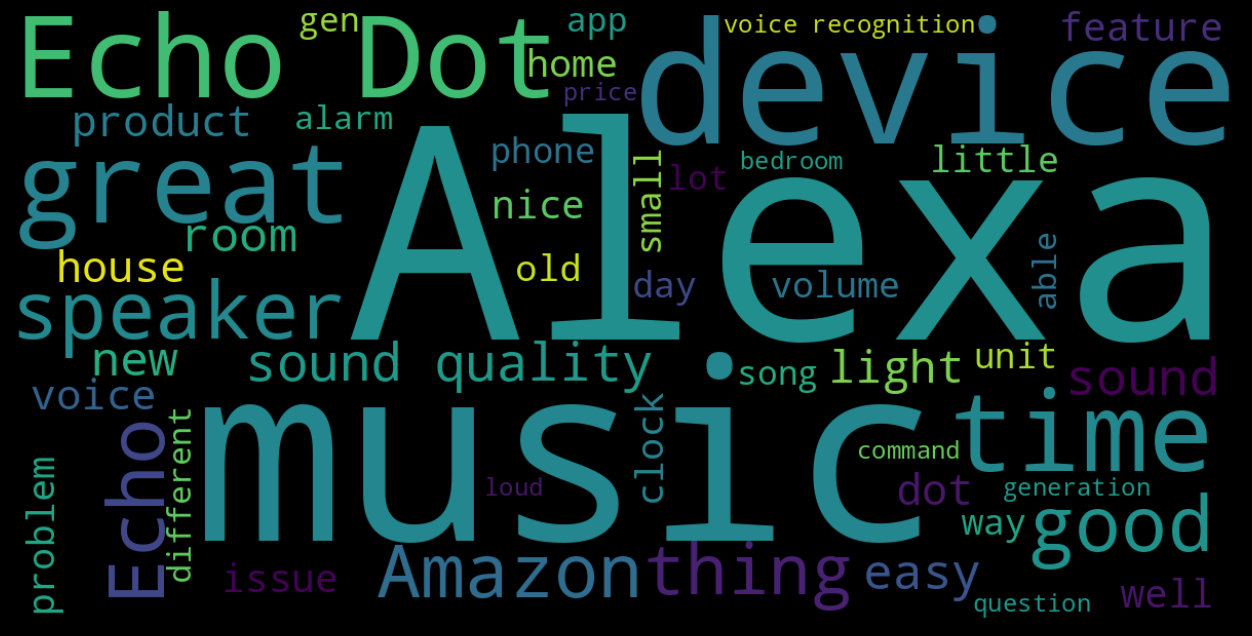

In [353]:
words_filtered = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop if token.pos_ in [
    'NOUN', 'ADJ', 'PROPN']]

wordcloud = WordCloud(background_color="black", max_words=50,
                      width=1200, height=600).generate(' '.join(words_filtered))

plt.figure(figsize=(16, 8), facecolor='k')
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


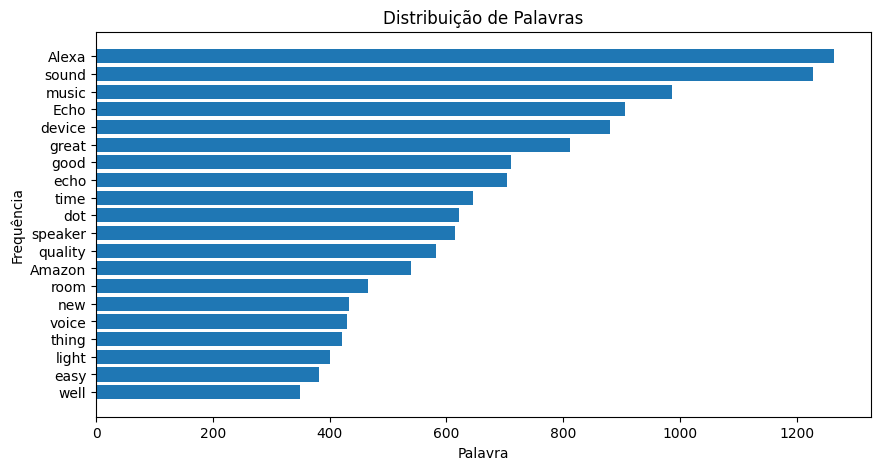

In [354]:
contagem = Counter(words_filtered).most_common(20)
words, freqs = [], []
for tup in contagem[::-1]:
    words.append(tup[0])
    freqs.append(tup[1])


# Criar um gráfico de barras para visualizar a distribuição de palavras
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(words, freqs)
plt.xlabel('Palavra')
plt.ylabel('Frequência')
plt.title('Distribuição de Palavras')
plt.show()


Hmm, parece que seria interessante remover "alexa", "device" e palavras do tipo...


## Limpeza usando tokenização, lematização e entidades nomeadas


### Inspeção


In [355]:
ents = [token for token in doc if token.ent_type]

print(f"{'token.text':^15} {'token.lemma_':^15} {'token.pos_':^15} {'token.tag_':^15} {'token.dep_':^15}"
      f"{'token.shape_':^15} {'token.is_alpha':^15} {'token.is_stop':^15} {'token.ent_type':^15} {'token.ent_type_':^15}")
for token in ents[:20]:
    print(f"{token.text:^15} {token.lemma_:^15} {token.pos_:^15} {token.tag_:^15} {token.dep_:^15}"
          f"{token.shape_:^15} {token.is_alpha:^15} {token.is_stop:^15} {token.ent_type:^15} {token.ent_type_:^15}")


  token.text     token.lemma_     token.pos_      token.tag_      token.dep_    token.shape_   token.is_alpha   token.is_stop  token.ent_type  token.ent_type_
      1st             1st             ADJ             JJ             amod            dxx              0               0              396           ORDINAL    
  Generation      Generation         PROPN            NNP          compound         Xxxxx             1               0              387            EVENT     
     Echo            Echo            PROPN            NNP            pobj           Xxxx              1               0              387            EVENT     
     Alexa           Alexa           PROPN            NNP          compound         Xxxxx             1               0              383             ORG      
     Alexa           Alexa           PROPN            NNP            pobj           Xxxxx             1               0              383             ORG      
   Trinidad        Trinidad          PROPN    

In [356]:
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"][:20])
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks][:10])


Verbs: ['love', 'recommend', 'trade', 'go', 'grow', 'downfall', 'seem', 'be', 'compare', 'say', 'get', 'play', 'find', 'see', 'return', 'get', 'love', 'have', 'interact', 'have']
Noun phrases: ['This', 'a great gift', 'someone', 'who', 'home', 'I', 'it', 'I', 'my 1st Generation Echo', 'the new model']


In [357]:
from spacy import displacy
displacy.render(doc[:100], style="ent", jupyter=True)


In [358]:
org_ents = [ent for ent in ents if ent.ent_type_ == "ORG"]
print(len(org_ents))
org_ents[:25]


3211


[Alexa,
 Alexa,
 Apple,
 Music,
 the,
 3rd,
 Gen,
 Echo,
 Alexa,
 the,
 3rd,
 Gen,
 Alexa,
 Loco,
 Loco,
 Alexa,
 Alexa,
 Buttons,
 Alexa,
 Alexa,
 Alexa,
 Amazon,
 Alexa,
 Alexa,
 Alexa]

In [359]:
len(doc)


201928

### Limpeza

Atributos adicionais para filtragem de entidades indesejadas


In [360]:
Token.set_extension("is_alexa", getter=lambda token: token.lemma_.lower() in [
                    "alexa", "alexas"], force=True)
Token.set_extension("is_echo", getter=lambda token: token.lemma_.lower() in [
                    "echo", "echos", "dot"], force=True)
Token.set_extension("is_amazon", getter=lambda token: bool(
    re.search("amazon(.[A-Za-z]*)?", token.lemma_.lower())), force=True)
Token.set_extension(
    "is_device", getter=lambda token: token.lemma_.lower() == "device", force=True)
len([token for token in doc if token._.is_alexa])


1490

In [361]:
org_ends_s = pd.Series(org_ents)
org_ends_s[~org_ends_s.map(
    lambda t: t._.is_alexa or t._.is_echo or t._.is_amazon or t._.is_device)].tolist()[:25]


[Apple,
 Music,
 the,
 3rd,
 Gen,
 the,
 3rd,
 Gen,
 Loco,
 Loco,
 Buttons,
 up.4,
 USB,
 USB,
 The,
 Spotify,
 Auto,
 Honeywell,
 Clock,
 IFTTT,
 YouTube,
 Apple,
 Wikipedia,
 Whosits.com,
 Clock]

In [362]:
filtered_ers = pd.Series(
    [token.text for token in doc
        if token._.is_alexa or token._.is_echo or token._.is_amazon or token._.is_device
     ]).unique().tolist()
len(filtered_ers)


35

In [363]:
words_filtered = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop if token.pos_ in [
    'NOUN', 'ADJ', 'PROPN']]


In [364]:
words_fileter_without_ners = [
    w for w in words_filtered if w not in filtered_ers]


In [365]:
print(len(words_filtered))
print(len(words_fileter_without_ners))


48097
42380


/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


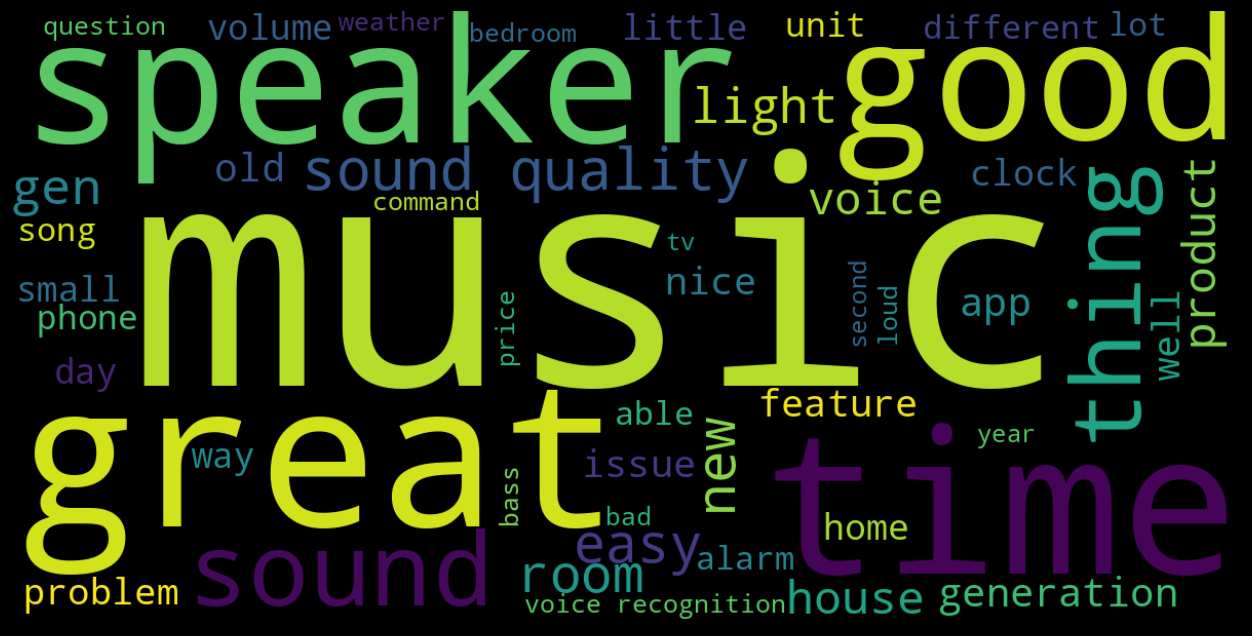

In [366]:
wordcloud = WordCloud(background_color="black", max_words=50, width=1200,
                      height=600).generate(' '.join(words_fileter_without_ners))

plt.figure(figsize=(16, 8), facecolor='k')
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


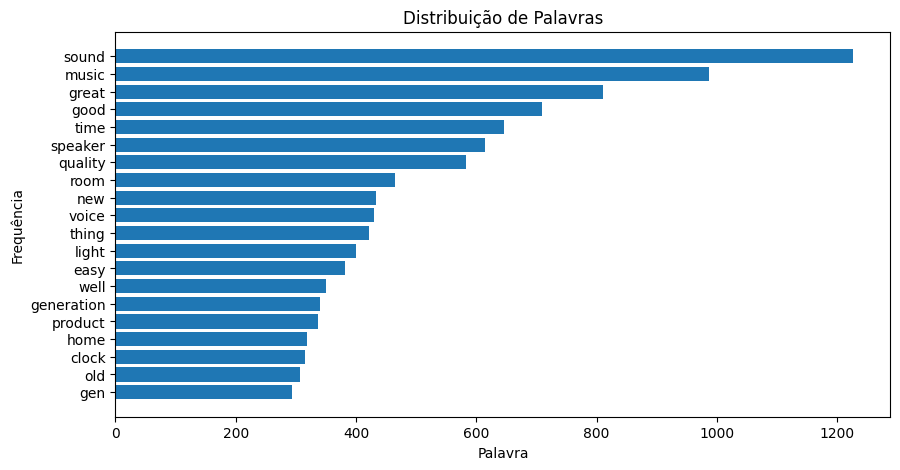

In [367]:
contagem = Counter(words_fileter_without_ners).most_common(20)
words, freqs = [], []
for tup in contagem[::-1]:
    words.append(tup[0])
    freqs.append(tup[1])


# Criar um gráfico de barras para visualizar a distribuição de palavras
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(words, freqs)
plt.xlabel('Palavra')
plt.ylabel('Frequência')
plt.title('Distribuição de Palavras')
plt.show()


### Limpando o dataset


In [368]:
Token.set_extension("is_alexa", getter=lambda token: token.lemma_.lower() in [
                    "alexa", "alexas"], force=True)
Token.set_extension("is_echo", getter=lambda token: token.lemma_.lower() in [
                    "echo", "echos", "dot"], force=True)
Token.set_extension("is_amazon", getter=lambda token: bool(
    re.search("amazon(.[A-Za-z]*)?", token.lemma_.lower())), force=True)
Token.set_extension(
    "is_device", getter=lambda token: token.lemma_.lower() == "device", force=True)


In [369]:
def clean_doc(doc):
    filtered_ers = pd.Series(
        [token.text for token in doc
            if token._.is_alexa or token._.is_echo or token._.is_amazon or token._.is_device
         ]).unique().tolist()
    len(filtered_ers)

    words_filtered = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.pos_ in [
        'NOUN', 'ADJ', 'PROPN']]
    return " ".join([w for w in words_filtered if w not in filtered_ers])


In [370]:
df["docs"] = df["reviews"].map(nlp)
df["clean_reviews"] = df["docs"].map(clean_doc)
df.head()


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls,docs,clean_reviews
23096,2023-01-12,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,general,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Karimeriossss,I bought this as a gift,en,This is a great gift for someone who loves to ...,en,5,1,"(This, is, a, great, gift, for, someone, who, ...",great gift active home
9758,2021-12-03,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,positive,Color: Glacier WhiteConfiguration: Echo,Color: Glacier WhiteConfiguration: Echo,61.76,0.00,0.00,Penang1970,I Love Alexa!!!,en,I traded in my 1st Generation Echo for the new...,en,5,0,"(I, traded, in, my, 1st, Generation, Echo, for...",Generation new model black cylinder blue globe...
27374,2022-12-29,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,positive,Color: CharcoalConfiguration: Device only,Color: CharcoalConfiguration: Device only,29.99,0.00,0.00,Tyrell singh,Good deal and happy lighting,en,Only downfall with Alexa is it seems like ther...,en,4,0,"(Only, downfall, with, Alexa, is, it, seems, l...",integration Trinidad Tobago example news radio...
37385,2021-04-06,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,critical,Color: CharcoalConfiguration: Echo,Color: CharcoalConfiguration: Echo,61.76,0.00,0.00,Jim Tellier,Helllloooooo?,en,The microphone sensitivity of this model is po...,en,3,0,"(The, microphone, sensitivity, of, this, model...",microphone sensitivity model poor Gen dot time...
21678,2023-02-27,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,general,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Marilyn Hupp,Reasonable Alexa,en,I love the echo dot I have an echo show but th...,en,5,0,"(I, love, the, echo, dot, I, have, an, echo, s...",well hard time doti problem


In [371]:
df[["reviews", "clean_reviews"]].applymap(len).head()


,reviews,clean_reviews
23096,88,22
9758,172,75
27374,219,84
37385,564,179
21678,255,27


In [372]:
df.iloc[0][["reviews", "clean_reviews"]]


reviews          This is a great gift for someone who loves to ...
clean_reviews                               great gift active home
Name: 23096, dtype: object

## Análise de sentimentos


In [373]:
blob = TextBlob(df.iloc[0]["reviews"])
print(blob.sentiment)

blob = TextBlob(df.iloc[0]["clean_reviews"])
print(blob.sentiment)

print(df.iloc[0][["stars"]])


Sentiment(polarity=0.22222222222222224, subjectivity=0.7000000000000001)
Sentiment(polarity=0.33333333333333337, subjectivity=0.675)
stars    5
Name: 23096, dtype: object


In [374]:
df["sentiment"] = df["clean_reviews"].map(lambda x: TextBlob(x).sentiment[0])
df["subjectivity"] = df["clean_reviews"].map(
    lambda x: TextBlob(x).sentiment[1])
df.head()


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls,docs,clean_reviews,sentiment,subjectivity
23096,2023-01-12,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,general,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Karimeriossss,I bought this as a gift,en,This is a great gift for someone who loves to ...,en,5,1,"(This, is, a, great, gift, for, someone, who, ...",great gift active home,0.333333,0.675000
9758,2021-12-03,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,positive,Color: Glacier WhiteConfiguration: Echo,Color: Glacier WhiteConfiguration: Echo,61.76,0.00,0.00,Penang1970,I Love Alexa!!!,en,I traded in my 1st Generation Echo for the new...,en,5,0,"(I, traded, in, my, 1st, Generation, Echo, for...",Generation new model black cylinder blue globe...,0.101212,0.368485
27374,2022-12-29,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,positive,Color: CharcoalConfiguration: Device only,Color: CharcoalConfiguration: Device only,29.99,0.00,0.00,Tyrell singh,Good deal and happy lighting,en,Only downfall with Alexa is it seems like ther...,en,4,0,"(Only, downfall, with, Alexa, is, it, seems, l...",integration Trinidad Tobago example news radio...,0.566667,0.716667
37385,2021-04-06,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,critical,Color: CharcoalConfiguration: Echo,Color: CharcoalConfiguration: Echo,61.76,0.00,0.00,Jim Tellier,Helllloooooo?,en,The microphone sensitivity of this model is po...,en,3,0,"(The, microphone, sensitivity, of, this, model...",microphone sensitivity model poor Gen dot time...,0.189583,0.537500
21678,2023-02-27,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,general,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Marilyn Hupp,Reasonable Alexa,en,I love the echo dot I have an echo show but th...,en,5,0,"(I, love, the, echo, dot, I, have, an, echo, s...",well hard time doti problem,-0.291667,0.541667


Há alguma correlação?


In [375]:
prod_id_map = {
    'Echo_Dot_3rd_Gen_2018_Charcoal': 1,
    'Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa': 2,
    'Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa': 3,
    'Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa': 4
}

               prod_id  base_price     stars  helpfuls  sentiment   
prod_id       1.000000    0.137740  0.110780 -0.009089   0.064777  \
base_price    0.137740    1.000000 -0.016084 -0.027948   0.012106   
stars         0.110780   -0.016084  1.000000  0.007759   0.401904   
helpfuls     -0.009089   -0.027948  0.007759  1.000000  -0.007694   
sentiment     0.064777    0.012106  0.401904 -0.007694   1.000000   
subjectivity  0.025285    0.045437  0.128343 -0.010068   0.481886   

              subjectivity  
prod_id           0.025285  
base_price        0.045437  
stars             0.128343  
helpfuls         -0.010068  
sentiment         0.481886  
subjectivity      1.000000  


<Axes: >

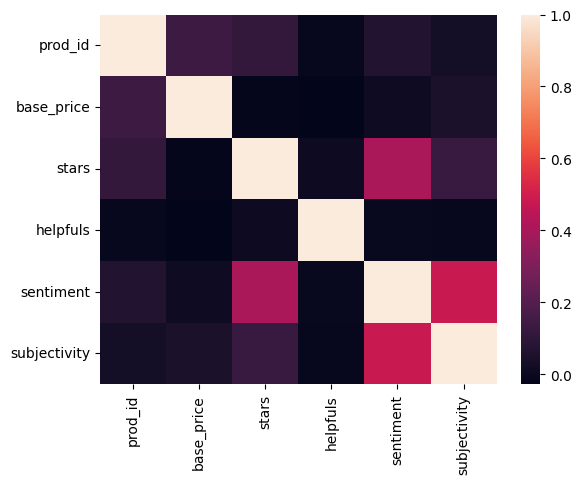

In [376]:
tmp_df = df.copy()
tmp_df["prod_id"] = df["product_name"].map(lambda x: prod_id_map[x])


print(tmp_df[["prod_id", "base_price", "stars",
        "helpfuls", "sentiment", "subjectivity"]].corr())

sns.heatmap(tmp_df[["prod_id", "base_price", "stars",
            "helpfuls", "sentiment", "subjectivity"]].corr())


In [377]:
df.groupby("product_name").agg({"sentiment": "mean", "stars": "mean"})


,sentiment,stars
product_name,,
Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa,0.232706,3.891658
Echo_Dot_3rd_Gen_2018_Charcoal,0.225266,3.93887
Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa,0.226610,3.996394
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa,0.286630,4.353293


Há certa correlação positiva entra sentimento e estrelas


E com o tempo?


Vamos fracionar em períodos de 90 dias


In [378]:
print(df.dates.min())
print(df.dates.max())
print(df.dates.max() - df.dates.min())
print("bins", ((df.dates.max() - df.dates.min()).days/90))
print((df.dates.max() - df.dates.min()) /
      ((df.dates.max() - df.dates.min()).days/90))


2019-08-01 00:00:00
2023-04-30 00:00:00
1368 days 00:00:00
bins 15.2
90 days 00:00:00


In [379]:
df["date_bins"] = pd.cut(df["dates"], int(
    ((df.dates.max() - df.dates.min()).days/90)))
df["date_bins"] = df["date_bins"].map(lambda x: x.left.date())
df.head()


,dates,country,product_name,orig_type,configuration,color,base_price,config_price,bundle_price,names,...,title_lang,reviews,review_lang,stars,helpfuls,docs,clean_reviews,sentiment,subjectivity,date_bins
23096,2023-01-12,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,general,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Karimeriossss,...,en,This is a great gift for someone who loves to ...,en,5,1,"(This, is, a, great, gift, for, someone, who, ...",great gift active home,0.333333,0.675000,2022-10-29
9758,2021-12-03,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,positive,Color: Glacier WhiteConfiguration: Echo,Color: Glacier WhiteConfiguration: Echo,61.76,0.00,0.00,Penang1970,...,en,I traded in my 1st Generation Echo for the new...,en,5,0,"(I, traded, in, my, 1st, Generation, Echo, for...",Generation new model black cylinder blue globe...,0.101212,0.368485,2021-10-29
27374,2022-12-29,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,positive,Color: CharcoalConfiguration: Device only,Color: CharcoalConfiguration: Device only,29.99,0.00,0.00,Tyrell singh,...,en,Only downfall with Alexa is it seems like ther...,en,4,0,"(Only, downfall, with, Alexa, is, it, seems, l...",integration Trinidad Tobago example news radio...,0.566667,0.716667,2022-10-29
37385,2021-04-06,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,critical,Color: CharcoalConfiguration: Echo,Color: CharcoalConfiguration: Echo,61.76,0.00,0.00,Jim Tellier,...,en,The microphone sensitivity of this model is po...,en,3,0,"(The, microphone, sensitivity, of, this, model...",microphone sensitivity model poor Gen dot time...,0.189583,0.537500,2021-01-29
21678,2023-02-27,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,general,Configuration: Device only,Configuration: Device only,22.92,15.06,59.98,Marilyn Hupp,...,en,I love the echo dot I have an echo show but th...,en,5,0,"(I, love, the, echo, dot, I, have, an, echo, s...",well hard time doti problem,-0.291667,0.541667,2023-01-28


In [380]:
df["product_name"].unique()


array(['Echo_Dot_3rd_Gen_2018_Charcoal',
       'Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa',
       'Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa',
       'Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa'],
      dtype=object)

               prod_id  base_price     stars  helpfuls  sentiment   
prod_id       1.000000    0.137740  0.110780 -0.009089   0.064777  \
base_price    0.137740    1.000000 -0.016084 -0.027948   0.012106   
stars         0.110780   -0.016084  1.000000  0.007759   0.401904   
helpfuls     -0.009089   -0.027948  0.007759  1.000000  -0.007694   
sentiment     0.064777    0.012106  0.401904 -0.007694   1.000000   
subjectivity  0.025285    0.045437  0.128343 -0.010068   0.481886   
date_bins     0.460075   -0.169104  0.228409  0.034946   0.094563   

              subjectivity  date_bins  
prod_id           0.025285   0.460075  
base_price        0.045437  -0.169104  
stars             0.128343   0.228409  
helpfuls         -0.010068   0.034946  
sentiment         0.481886   0.094563  
subjectivity      1.000000  -0.024306  
date_bins        -0.024306   1.000000  


<Axes: >

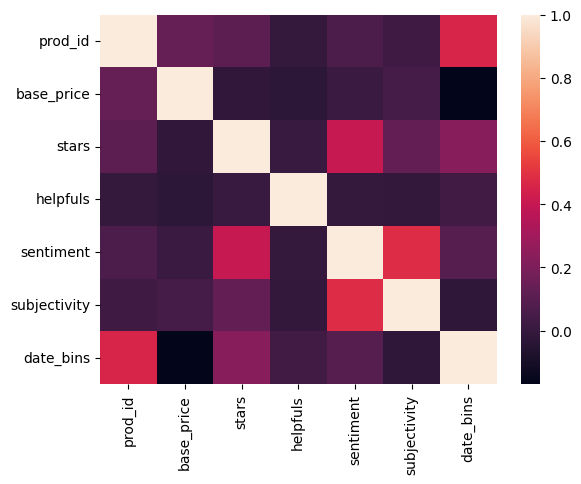

In [381]:
tmp_df = df.copy()
tmp_df["prod_id"] = df["product_name"].map(lambda x: prod_id_map[x])
tmp_df["date_bins"] = df["date_bins"].map(
    lambda x: 10000*x.year + 100*x.month + x.day).astype(int)
# tmp_df[["prod_id", "base_price", "stars", "helpfuls","sentiment","subjectivity","date_bins"]].corr()
print(tmp_df[["prod_id", "base_price", "stars", "helpfuls",
      "sentiment", "subjectivity", "date_bins"]].corr())
sns.heatmap(tmp_df[["prod_id", "base_price", "stars", "helpfuls",
            "sentiment", "subjectivity", "date_bins"]].corr())


Há uma certa correlação entre o período e preço, além de uma baixa correlação entre período e estrelas

In [382]:
df.groupby("date_bins")["date_bins"].count()

date_bins
2019-07-30      13
2019-10-31      75
2020-01-30      30
2020-04-30      30
2020-07-30      38
2020-10-30     147
2021-01-29     121
2021-04-30      84
2021-07-30      66
2021-10-29     179
2022-01-29     134
2022-04-30     172
2022-07-30     311
2022-10-29    1242
2023-01-28     816
Name: date_bins, dtype: int64

In [383]:
df.groupby("date_bins").agg({"base_price":"mean"})

,base_price
date_bins,
2019-07-30,22.920000
2019-10-31,22.920000
2020-01-30,22.920000
2020-04-30,22.920000
2020-07-30,25.986316
2020-10-30,54.097687
2021-01-29,55.661157
2021-04-30,52.512381
2021-07-30,49.401818


In [384]:
df.groupby("date_bins").agg({"stars":"mean"})

,stars
date_bins,
2019-07-30,2.615385
2019-10-31,3.24
2020-01-30,3.033333
2020-04-30,3.0
2020-07-30,2.894737
2020-10-30,3.190476
2021-01-29,3.408333
2021-04-30,3.416667
2021-07-30,3.181818


Há uma correlação entre a data da avaliação e o preço do produto, que se explica provávelmente por que os preços são os preços de hoje. Produtos mais antigos custam menos hoje.

In [385]:
print(df.dates.min())
print(df.dates.max())
df.groupby(["product_name", "date_bins"]).agg(
    {"sentiment": "mean", "stars": "mean"}).sort_values(["sentiment", "stars"], ascending=False).head(20)


2019-08-01 00:00:00
2023-04-30 00:00:00


sentiment   
product_name                                       date_bins               
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_... 2022-10-29   0.323041  \
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2022-07-30   0.322845   
Echo_Dot_3rd_Gen_2018_Charcoal                     2022-10-29   0.312720   
                                                   2022-07-30   0.309710   
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2021-10-29   0.303622   
                                                   2022-04-30   0.302684   
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_... 2022-07-30   0.261182   
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2022-01-29   0.244089   
                                                   2023-01-28   0.241486   
                                                   2020-07-30   0.236825   
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_... 2023-01-28   0.233505   
Echo_Dot_3rd_Gen_2018_Charcoal                     2023-01-28   0.231178   
Echo_Dot_5th_Gen_2022_release_With_bigger_vibra... 2022-10-29   0.226973   
                                                   2023-01-28   0.226694   
                                                   2022-07-30   0.217851   
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2022-10-29   0.207440   
Echo_Dot_3rd_Gen_2018_Charcoal                     2022-04-30   0.206322   
                                                   2021-10-29   0.197911   
                                                   2020-01-30   0.185869   
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2021-04-30   0.177283   

                                                                  stars  
product_name                                       date_bins             
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_... 2022-10-29  4.458678  
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2022-07-30  4.391304  
Echo_Dot_3rd_Gen_2018_Charcoal                     2022-10-29  4.692683  
                                                   2022-07-30  4.566176  
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2021-10-29  4.028369  
                                                   2022-04-30  4.440945  
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_... 2022-07-30  4.243243  
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2022-01-29  4.230769  
                                                   2023-01-28  3.677419  
                                                   2020-07-30  3.666667  
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_... 2023-01-28  4.203822  
Echo_Dot_3rd_Gen_2018_Charcoal                     2023-01-28  4.248227  
Echo_Dot_5th_Gen_2022_release_With_bigger_vibra... 2022-10-29  4.002088  
                                                   2023-01-28  4.027273  
                                                   2022-07-30  3.434783  
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2022-10-29  3.743243  
Echo_Dot_3rd_Gen_2018_Charcoal                     2022-04-30  3.844444  
                                                   2021-10-29       3.5  
                                                   2020-01-30  3.033333  
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2021-04-30  3.578125

O período também apresenta uma leve correlação com a quantidade de estrelas


In [386]:
df.groupby(["product_name"]).agg(
    {"sentiment": "mean", "stars": "mean"}).sort_values(["sentiment", "stars"], ascending=False)

,sentiment,stars
product_name,,
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa,0.286630,4.353293
Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa,0.232706,3.891658
Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa,0.226610,3.996394
Echo_Dot_3rd_Gen_2018_Charcoal,0.225266,3.93887


Disparado, o preferido do público é o Echo Dot 5 com relógio. Talvez isso explique a palavra "time" aparecer tanto na nuvem de palavras

## Tópicos - o quê as pessoas estão dizendo?

In [387]:
def analyze_topics(df):
    def make_n_grams(text):
        text = text.split()
        bigram = Phrases(text, min_count=5, threshold=100)
        trigram = Phrases(bigram[text], threshold=100)
        return trigram[bigram[text]]

    df["ngrams"] = df["clean_reviews"].map(make_n_grams)

    dictionary = Dictionary(df['ngrams'])
    corpus = [dictionary.doc2bow(text) for text in df['ngrams']]

    num_topics = 5

    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

    for i, topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=5):
        print('Topic {}: {}'.format(i, topic))

    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    return(vis)
analyze_topics(df)

Topic 0: 0.079*"sound" + 0.047*"quality" + 0.032*"speaker" + 0.021*"room" + 0.015*"generation"
Topic 1: 0.042*"music" + 0.023*"sound" + 0.022*"good" + 0.021*"speaker" + 0.017*"time"
Topic 2: 0.022*"new" + 0.021*"gift" + 0.016*"support" + 0.015*"hour" + 0.013*"tech"
Topic 3: 0.037*"voice" + 0.023*"new" + 0.019*"old" + 0.016*"recognition" + 0.013*"sound"
Topic 4: 0.043*"great" + 0.031*"clock" + 0.023*"light" + 0.020*"easy" + 0.017*"sound"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.044386  0.022222       1        1  36.141283
4     -0.022333  0.126394       2        1  24.586711
0     -0.142650 -0.005737       3        1  14.395624
3      0.011660 -0.167908       4        1  13.063527
2      0.197709  0.025030       5        1  11.812855, topic_info=        Term         Freq        Total Category  logprob  loglift
13     sound  1098.000000  1098.000000  Default  30.0000  30.0000
36   quality   505.000000   505.000000  Default  29.0000  29.0000
95     clock   347.000000   347.000000  Default  28.0000  28.0000
103    voice   382.000000   382.000000  Default  27.0000  27.0000
68   speaker   575.000000   575.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
33     music    54.112577   896.442804   Topic5  -4.5400  -0.6714
256    issue    30.403616   188.307926   Topic5  -5.1165   0.3125
222  product    30.835285   307.918937   Topic5  -5.1025  -0.1652
98     thing    29.524971   383.491100   Topic5  -5.1459  -0.4281
3       home    26.938964   275.652424   Topic5  -5.2375  -0.1896

[371 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1397      1  0.906873       Alex
15        1  0.980832      Apple
1591      4  0.834346      Blink
236       1  0.776703  Bluetooth
236       2  0.052658  Bluetooth
...     ...       ...        ...
196       3  0.155296       year
196       4  0.116472       year
196       5  0.357180       year
1135      5  0.772869         yr
672       2  0.831672          z

[679 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 4, 3])

Vamos ver o quê os mais críticos estão dizendo

In [388]:
analyze_topics(df[df["stars"] < df["stars"].quantile(0.1)])

/tmp/ipykernel_7146/776637196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ngrams"] = df["clean_reviews"].map(make_n_grams)


Topic 0: 0.052*"music" + 0.016*"new" + 0.015*"product" + 0.013*"time" + 0.012*"speaker"
Topic 1: 0.018*"phone" + 0.017*"Wi" + 0.015*"Fi" + 0.011*"month" + 0.010*"app"
Topic 2: 0.028*"time" + 0.013*"thing" + 0.012*"sound" + 0.011*"music" + 0.011*"light"
Topic 3: 0.014*"time" + 0.013*"new" + 0.012*"hour" + 0.010*"thing" + 0.010*"old"
Topic 4: 0.023*"music" + 0.016*"song" + 0.015*"quality" + 0.014*"gen" + 0.014*"service"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.024490 -0.013743       1        1  30.247123
2     -0.071947 -0.036273       2        1  26.306198
3      0.045610 -0.095221       3        1  17.199067
4     -0.066191  0.085141       4        1  15.688913
1      0.117019  0.060096       5        1  10.558699, topic_info=        Term        Freq       Total Category  logprob  loglift
13     music  124.000000  124.000000  Default  30.0000  30.0000
566       Wi   12.000000   12.000000  Default  29.0000  29.0000
564       Fi   12.000000   12.000000  Default  28.0000  28.0000
200    phone   27.000000   27.000000  Default  27.0000  27.0000
134  service   25.000000   25.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
90     sound    3.188749   42.835522   Topic5  -5.1655  -0.3495
13     music    3.625422  124.766750   Topic5  -5.0372  -1.2903
83      time    3.280197   80.794964   Topic5  -5.1373  -0.9558
233     room    2.804695   31.618872   Topic5  -5.2939  -0.1742
238     year    2.658655   26.785201   Topic5  -5.3473  -0.0618

[371 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
469       1  0.812257     AI
469       2  0.203064     AI
239       4  0.670228     AL
240       4  0.891441     Al
879       1  0.820774  Alexi
...     ...       ...    ...
238       1  0.336006   year
238       2  0.298672   year
238       3  0.186670   year
238       4  0.074668   year
238       5  0.112002   year

[590 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 5, 2])

Notável as palavras "time", além de "music", "sound", "song" e "quality" em quase todos os tópicos

E os mais positivos

In [395]:
analyze_topics(df[df["stars"] >= df["stars"].quantile(0.1)])

/tmp/ipykernel_7146/776637196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ngrams"] = df["clean_reviews"].map(make_n_grams)


Topic 0: 0.028*"music" + 0.021*"smart" + 0.017*"home" + 0.017*"great" + 0.014*"room"
Topic 1: 0.031*"time" + 0.025*"music" + 0.019*"easy" + 0.019*"great" + 0.013*"thing"
Topic 2: 0.032*"sound" + 0.031*"generation" + 0.025*"new" + 0.024*"gen" + 0.022*"well"
Topic 3: 0.075*"sound" + 0.049*"great" + 0.041*"good" + 0.037*"quality" + 0.036*"speaker"
Topic 4: 0.069*"clock" + 0.026*"display" + 0.020*"night" + 0.018*"bright" + 0.018*"feature"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.006240 -0.091587       1        1  27.567092
3     -0.116307 -0.031940       2        1  24.599325
2     -0.098620  0.172827       3        1  23.420157
1     -0.009877 -0.100232       4        1  17.128987
4      0.231044  0.050933       5        1   7.284438, topic_info=           Term         Freq        Total Category  logprob  loglift
95        clock   337.000000   337.000000  Default  30.0000  30.0000
13        sound  1063.000000  1063.000000  Default  29.0000  29.0000
74   generation   279.000000   279.000000  Default  28.0000  28.0000
2         great   771.000000   771.000000  Default  27.0000  27.0000
36      quality   472.000000   472.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
129        easy    13.309497   375.217637   Topic5  -5.3269  -0.7196
30         good    14.108349   606.082782   Topic5  -5.2686  -1.1408
85        small    11.283698   161.312927   Topic5  -5.4921  -0.0406
33        music    13.351893   734.374595   Topic5  -5.3238  -1.3879
119       phone    11.011000   151.895361   Topic5  -5.5165  -0.0049

[371 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2155      5  0.853083     Alexis
196       1  0.060390  Bluetooth
196       2  0.543509  Bluetooth
196       3  0.045292  Bluetooth
196       4  0.271754  Bluetooth
...     ...       ...        ...
174       1  0.119731       year
174       2  0.538789       year
174       3  0.089798       year
174       4  0.139686       year
174       5  0.099776       year

[677 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5])

E por produto?

In [391]:
sub_dfs = {}
for product_name in df["product_name"].unique().tolist():
  sub_dfs[product_name] = df[df["product_name"] == product_name]
sub_dfs

{'Echo_Dot_3rd_Gen_2018_Charcoal':            dates           country                    product_name orig_type   
 23096 2023-01-12  United States 🇺🇸  Echo_Dot_3rd_Gen_2018_Charcoal   general  \
 21678 2023-02-27  United States 🇺🇸  Echo_Dot_3rd_Gen_2018_Charcoal   general   
 4344  2021-08-14  United States 🇺🇸  Echo_Dot_3rd_Gen_2018_Charcoal  positive   
 34114 2022-04-01  United States 🇺🇸  Echo_Dot_3rd_Gen_2018_Charcoal  critical   
 3123  2022-12-21  United States 🇺🇸  Echo_Dot_3rd_Gen_2018_Charcoal  positive   
 ...          ...               ...                             ...       ...   
 34600 2020-05-04  United States 🇺🇸  Echo_Dot_3rd_Gen_2018_Charcoal  critical   
 23265 2022-11-01  United States 🇺🇸  Echo_Dot_3rd_Gen_2018_Charcoal   general   
 26349 2022-10-17  United States 🇺🇸  Echo_Dot_3rd_Gen_2018_Charcoal   general   
 34237 2020-06-16  United States 🇺🇸  Echo_Dot_3rd_Gen_2018_Charcoal  critical   
 25858 2022-06-02  United States 🇺🇸  Echo_Dot_3rd_Gen_2018_Charcoal   gener

In [396]:
df["product_name"].unique().tolist()

['Echo_Dot_3rd_Gen_2018_Charcoal',
 'Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa',
 'Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa',
 'Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa']

In [ ]:
analyze_topics(df[df["stars"] >= df["stars"].quantile(0.1)])

In [399]:
echo_3_df = sub_dfs["Echo_Dot_3rd_Gen_2018_Charcoal"]
echo_4_df = sub_dfs["Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa"]
echo_5_df = sub_dfs["Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa"]
echo_5_clock_df = sub_dfs["Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa"]


In [400]:
analyze_topics(echo_3_df[echo_3_df["stars"] < echo_3_df["stars"].quantile(0.1)])

/tmp/ipykernel_7146/776637196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ngrams"] = df["clean_reviews"].map(make_n_grams)


Topic 0: 0.047*"music" + 0.023*"time" + 0.015*"room" + 0.013*"Google" + 0.013*"thing"
Topic 1: 0.027*"time" + 0.027*"music" + 0.027*"thing" + 0.015*"speaker" + 0.015*"service"
Topic 2: 0.018*"issue" + 0.015*"hour" + 0.012*"problem" + 0.010*"bass" + 0.010*"simple"
Topic 3: 0.019*"phone" + 0.018*"app" + 0.016*"day" + 0.013*"music" + 0.013*"song"
Topic 4: 0.024*"app" + 0.017*"system" + 0.016*"time" + 0.015*"song" + 0.012*"plug"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.088556  0.042767       1        1  25.945288
2     -0.130995  0.017016       2        1  20.588737
1     -0.000905  0.088714       3        1  20.423626
3      0.001640 -0.117687       4        1  18.328623
4      0.041704 -0.030811       5        1  14.713725, topic_info=       Term       Freq      Total Category  logprob  loglift
93    music  24.000000  24.000000  Default  30.0000  30.0000
42      app   9.000000   9.000000  Default  29.0000  29.0000
110   issue   6.000000   6.000000  Default  28.0000  28.0000
21   system   3.000000   3.000000  Default  27.0000  27.0000
128   phone   6.000000   6.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
93    music   1.320150  24.051983   Topic5  -4.8252  -0.9861
12     home   0.845900   5.417441   Topic5  -5.2703   0.0594
212   power   0.785431   3.243071   Topic5  -5.3444   0.4983
50    great   0.788747   5.327310   Topic5  -5.3402   0.0062
166   month   0.749953   4.501949   Topic5  -5.3907   0.1241

[291 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
177       1  0.954345      AI
426       1  0.954354   Alexi
526       4  0.768754  Alexia
366       2  0.986321     App
138       4  0.775372    Bose
...     ...       ...     ...
102       1  0.127173    year
102       2  0.127173    year
102       3  0.254347    year
102       4  0.254347    year
102       5  0.127173    year

[366 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5])

In [402]:
analyze_topics(echo_4_df[echo_4_df["stars"] < echo_4_df["stars"].quantile(0.2)])

/tmp/ipykernel_7146/776637196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ngrams"] = df["clean_reviews"].map(make_n_grams)


Topic 0: 0.025*"music" + 0.014*"room" + 0.014*"light" + 0.013*"song" + 0.012*"cord"
Topic 1: 0.035*"sound" + 0.020*"quality" + 0.012*"speaker" + 0.012*"smart" + 0.012*"issue"
Topic 2: 0.038*"gen" + 0.028*"time" + 0.018*"music" + 0.015*"good" + 0.015*"sound"
Topic 3: 0.054*"music" + 0.029*"new" + 0.015*"generation" + 0.012*"playlist" + 0.011*"month"
Topic 4: 0.020*"sound" + 0.016*"quality" + 0.015*"Gen" + 0.014*"unit" + 0.013*"voice"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.047140 -0.016650       1        1  30.933726
4      0.067888 -0.047589       2        1  24.309299
0     -0.081767  0.102768       3        1  18.086588
3     -0.110481 -0.082012       4        1  14.534842
1      0.077220  0.043483       5        1  12.135546, topic_info=        Term       Freq      Total Category  logprob  loglift
13     music  63.000000  63.000000  Default  30.0000  30.0000
46       new  27.000000  27.000000  Default  29.0000  29.0000
103      gen  48.000000  48.000000  Default  28.0000  28.0000
49     sound  53.000000  53.000000  Default  27.0000  27.0000
77   quality  25.000000  25.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
103      gen   3.435693  48.095543   Topic5  -4.7590  -0.5299
28     house   2.099227  13.780798   Topic5  -5.2517   0.2273
13     music   2.270435  63.845708   Topic5  -5.1733  -1.2275
69   product   2.101388  17.156523   Topic5  -5.2507   0.0093
104    great   2.079484  16.966416   Topic5  -5.2611   0.0099

[328 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
155       3  0.671969     AL
916       5  0.718833    Add
156       3  0.896277     Al
1015      2  0.860080    App
840       4  0.936277  Audio
...     ...       ...    ...
82        3  0.094037  worth
82        5  0.282110  worth
508       1  0.196216  wrong
508       3  0.196216  wrong
508       4  0.588647  wrong

[526 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 4, 2])

In [403]:
analyze_topics(echo_5_df[echo_5_df["stars"] < echo_5_df["stars"].quantile(0.1)])

/tmp/ipykernel_7146/776637196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ngrams"] = df["clean_reviews"].map(make_n_grams)


Topic 0: 0.040*"music" + 0.022*"wifi" + 0.022*"support" + 0.017*"device" + 0.017*"Apple"
Topic 1: 0.038*"Wi" + 0.038*"Fi" + 0.025*"phone" + 0.021*"music" + 0.017*"old"
Topic 2: 0.023*"music" + 0.016*"Fi" + 0.016*"Wi" + 0.016*"product" + 0.016*"bad"
Topic 3: 0.018*"item" + 0.018*"frustrating" + 0.018*"week" + 0.018*"shipping" + 0.013*"horrible"
Topic 4: 0.019*"joke" + 0.014*"warranty" + 0.014*"room" + 0.014*"setting" + 0.014*"new"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.116893 -0.025597       1        1  31.185473
1      0.035524  0.122717       2        1  21.565613
4     -0.104593  0.015745       3        1  19.407418
0      0.013734 -0.088564       4        1  14.923678
3     -0.061558 -0.024300       5        1  12.917818, topic_info=            Term       Freq      Total Category  logprob  loglift
65            Wi  10.000000  10.000000  Default  30.0000  30.0000
167           Fi  10.000000  10.000000  Default  29.0000  29.0000
96          wifi   4.000000   4.000000  Default  28.0000  28.0000
59       support   5.000000   5.000000  Default  27.0000  27.0000
379  frustrating   2.000000   2.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
187      factory   0.667581   2.607373   Topic5  -4.9869   0.6841
181     customer   0.667521   1.787635   Topic5  -4.9870   1.0615
138        cheap   0.667388   1.937647   Topic5  -4.9872   0.9807
40         sound   0.667387   3.856078   Topic5  -4.9872   0.2925
330      Spotify   0.667383   1.787643   Topic5  -4.9872   1.0613

[287 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
328       2  0.762720       AI
49        4  0.829100    Apple
192       1  0.723642     Best
193       1  0.723642      Buy
282       4  0.811987  DEVICES
...     ...       ...      ...
356       2  0.762729   wonder
48        2  0.762720    worth
136       1  0.631602     year
136       4  0.210534     year
136       5  0.210534     year

[342 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

In [405]:
analyze_topics(echo_5_clock_df[echo_5_clock_df["stars"] < echo_5_clock_df["stars"].quantile(0.21)])

/tmp/ipykernel_7146/776637196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ngrams"] = df["clean_reviews"].map(make_n_grams)


Topic 0: 0.023*"time" + 0.021*"speaker" + 0.015*"music" + 0.014*"product" + 0.014*"money"
Topic 1: 0.021*"gen" + 0.015*"new" + 0.013*"sound" + 0.012*"hour" + 0.011*"music"
Topic 2: 0.020*"music" + 0.019*"sound" + 0.017*"generation" + 0.016*"Gen" + 0.014*"time"
Topic 3: 0.016*"music" + 0.014*"voice" + 0.012*"volume" + 0.010*"ad" + 0.010*"junk"
Topic 4: 0.023*"generation" + 0.017*"speaker" + 0.015*"light" + 0.014*"new" + 0.012*"stereo"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.017014 -0.093611       1        1  41.121096
2     -0.098708  0.064444       2        1  25.176205
3      0.109341  0.062662       3        1  13.415387
1      0.026730 -0.058722       4        1  12.471413
4     -0.020349  0.025228       5        1   7.815900, topic_info=           Term       Freq      Total Category  logprob  loglift
52      speaker  28.000000  28.000000  Default  30.0000  30.0000
90   generation  24.000000  24.000000  Default  29.0000  29.0000
50          gen  19.000000  19.000000  Default  28.0000  28.0000
248         new  24.000000  24.000000  Default  27.0000  27.0000
157       light  14.000000  14.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
23      product   1.753278  25.292942   Topic5  -4.7302  -0.1200
99          app   1.465420  16.569419   Topic5  -4.9096   0.1236
251      second   1.224102   7.759462   Topic5  -5.0895   0.7023
391        tech   1.216539   6.478772   Topic5  -5.0957   0.8765
308     support   1.216503  15.560867   Topic5  -5.0957   0.0002

[334 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
658       1  0.848282       Alex
54        1  0.399138  Bluetooth
54        2  0.399138  Bluetooth
54        4  0.133046  Bluetooth
54        5  0.133046  Bluetooth
...     ...       ...        ...
257       4  0.744929   wxpensiv
53        1  0.533867       year
53        3  0.266933       year
53        4  0.133467       year
265       3  0.734652     yellow

[493 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5])

- Qualidade do som
- Problemas de conexão e pareamento (wifi, bluetooth)
- Problemas com o suporte ao cliente
- Problemas com a luz
- Problemas com o App